In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from configparser import SectionProxy
from logging import Logger
import logging
import log

from typing import Mapping, Optional, Dict, List, Tuple

link = 'https://andelenergi.dk/?obexport_format=csv&obexport_start=2022-08-10&obexport_end=2022-08-18&obexport_region=east'

region = 'east'
transport_overhead = 1.59 #DKK
log.setup()
logger = logging.getLogger(__name__)
logger.info("App starting")
logger.info('Getting price data')

def _make_El_price_URL(start_date: date, end_date: date, region: str) -> str:
    url = 'https://andelenergi.dk/?obexport_format=csv&obexport_start='+str(start_date)+'&obexport_end='+str(end_date)+'&obexport_region='+region
    return url

def get_El_price(start_date, end_date, region):
    url = _make_El_price_URL(start_date, end_date, region)
    try:
        el_data = pd.read_csv(url, decimal=',')
    except Exception as e:
        logger.exception('Error getting price data from: %s', url)
        return None, None
    el_data.Date = pd.to_datetime(el_data.Date)#.dt.date
    el_data2 = el_data.set_index('Date')
    el_data2.columns = pd.to_datetime(el_data2.columns)
    el_data2_st = el_data2.stack()
    dates = el_data2_st.index.get_level_values(0) 
    times = el_data2_st.index.get_level_values(1) 
    times.to_pydatetime()

    df = pd.DataFrame(columns= ['Date', 'Time', 'Datetime','Price'])
    df['Date'] = dates.date.astype(str)
    df['Time'] = times.time.astype(str)
    df['Hour'] = times.hour.astype(str)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' +df['Time'])
    df['Price'] = el_data2_st.values+transport_overhead
    df['Weekday'] = df['Datetime'].dt.day_name()
    df['Weekday'] = df['Weekday'].str.slice(0, 3)
    df['WeekHour'] = df['Weekday']+df['Hour']


    df_future = df[df['Datetime']>str(datetime.now()+timedelta(hours=-2))]
    df_future.reset_index(drop=True,inplace=True)
    new_data = False
    tomorrow = str(datetime.now().date()+timedelta(days=1)) 
    if tomorrow in df_future.Date.to_string():
        new_data = True
        logger.info('Prices for tomorrow available')
    else:
        logger.info('No price data for tomorrow')
    return df_future, new_data

now = datetime.today()
El_data, new_data = get_El_price(now.date()+timedelta(hours=-2), now.date()+timedelta(days=2), region)

print(El_data, new_data)

2022-11-26 17:37:32 - Oli - INFO - App starting
2022-11-26 17:37:32 - Oli - INFO - Getting price data
2022-11-26 17:37:33 - Oli - INFO - Prices for tomorrow available


          Date      Time            Datetime  Price Hour Weekday WeekHour
0   2022-11-26  16:00:00 2022-11-26 16:00:00  4.270   16     Sat    Sat16
1   2022-11-26  17:00:00 2022-11-26 17:00:00  4.528   17     Sat    Sat17
2   2022-11-26  18:00:00 2022-11-26 18:00:00  4.437   18     Sat    Sat18
3   2022-11-26  19:00:00 2022-11-26 19:00:00  4.102   19     Sat    Sat19
4   2022-11-26  20:00:00 2022-11-26 20:00:00  3.750   20     Sat    Sat20
5   2022-11-26  21:00:00 2022-11-26 21:00:00  3.527   21     Sat    Sat21
6   2022-11-26  22:00:00 2022-11-26 22:00:00  3.451   22     Sat    Sat22
7   2022-11-26  23:00:00 2022-11-26 23:00:00  3.167   23     Sat    Sat23
8   2022-11-27  00:00:00 2022-11-27 00:00:00  2.906    0     Sun     Sun0
9   2022-11-27  01:00:00 2022-11-27 01:00:00  2.846    1     Sun     Sun1
10  2022-11-27  02:00:00 2022-11-27 02:00:00  2.726    2     Sun     Sun2
11  2022-11-27  03:00:00 2022-11-27 03:00:00  2.515    3     Sun     Sun3
12  2022-11-27  04:00:00 2022-11-27 04

/tmp/ipykernel_3050/2617327451.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  El_data.Color[El_data.Price < 5] = 'orange'
/tmp/ipykernel_3050/2617327451.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  El_data.Hatch[El_data.Price < 5] = 'orange'
/tmp/ipykernel_3050/2617327451.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  El_data.Color[El_data.Price < 4] = 'yellow'
/tmp/ipykernel_3050/2617327451.py:72: SettingWithCopyWa

[8]


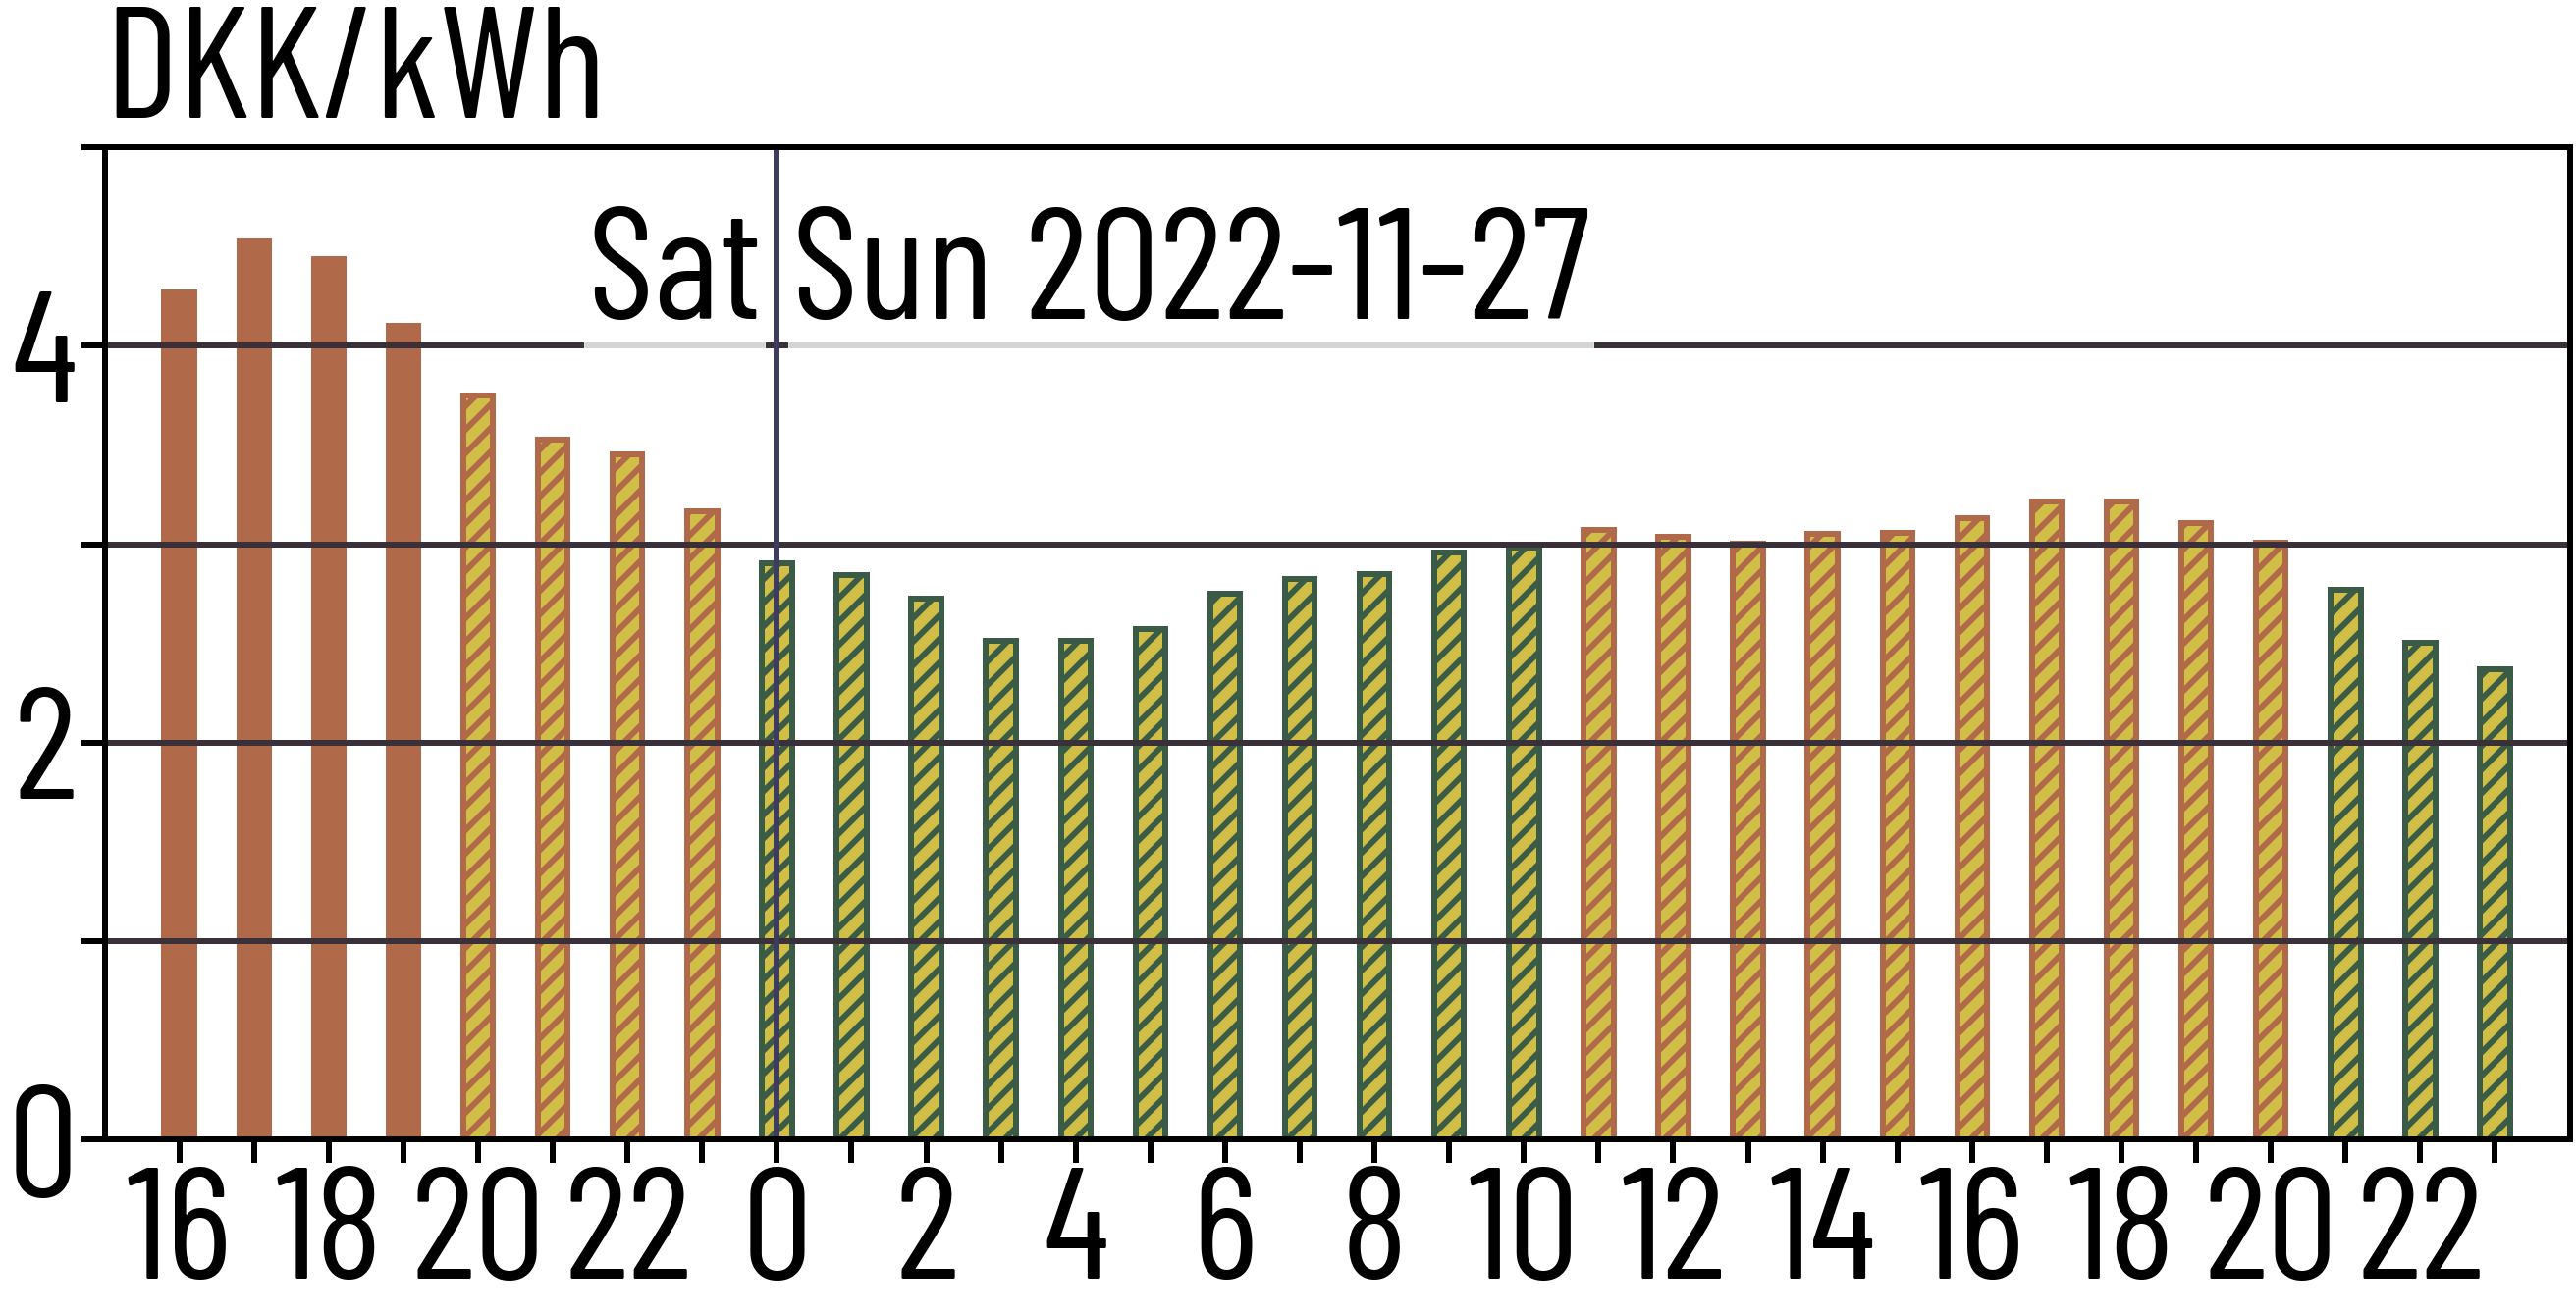

In [2]:
%matplotlib inline
import io
from PIL import Image
import utils
import configparser
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from PIL.Image import Dither

BLACK = 0
WHITE = 1
GREEN = 2
BLUE = 3
RED = 4
YELLOW = 5
ORANGE = 6
CLEAN = 7

PALETTE = {
    'black': tuple(np.array([57, 48, 57])/255),
    'white': tuple(np.array([255, 255, 255])/255),
    'green': tuple(np.array([58, 91, 70])/255),
    'blue':  tuple(np.array([61, 59, 94])/255),
    'red':   tuple(np.array([156, 72, 75])/255),
    'yellow':tuple(np.array([208, 190, 71])/255),
    'orange':tuple(np.array([177, 106, 73])/255),
    'clean': tuple(np.array([255, 255, 255])/255)
}

mpl.rcParams['hatch.linewidth'] = 8



CONFIG_FILENAME = 'config.ini'

with open(CONFIG_FILENAME) as f:
    config_parser = configparser.ConfigParser()
    config_parser.read_file(f)
    #logger.info('Config: %s', config_parser.items('general'))
    config = config_parser['general']
    fonts = utils.get_fonts(config)

panel_size = (600, 248)

#buf = io.BytesIO()
vsize = panel_size[1]
hsize = panel_size[0]
dpi = 80
factor = 6
linew = factor
mpl.rcParams['hatch.linewidth'] = linew
fontsize = 27
fig = plt.figure(figsize=((hsize/dpi*factor,vsize/dpi*factor)), frameon=False)
ax = plt.subplot()
font = 'barlow-condensed-regular.ttf'
font_path = 'fonts/barlow-condensed.regular.ttf'  # the location of the font file
font = fm.FontProperties(fname=font_path)  # get the font based on the font_path
vals = El_data.Price
hours = El_data.WeekHour

El_data['Color'] = ['red' for i in vals]
El_data['Hatch'] = ['red' for i in vals]

#El_data.Color[El_data.Price < El_data.Price.quantile(.4)] = 'orange'
#El_data.Hatch[El_data.Price < El_data.Price.quantile(.4)] = 'orange'

El_data.Color[El_data.Price < 5] = 'orange'
El_data.Hatch[El_data.Price < 5] = 'orange'

El_data.Color[El_data.Price < 4] = 'yellow'
El_data.Hatch[El_data.Price < 4] = 'orange'

El_data.Color[El_data.Price < 3] = 'yellow'
El_data.Hatch[El_data.Price < 3] = 'green'

El_data.Color[El_data.Price < 2] = 'green'
El_data.Hatch[El_data.Price < 2] = 'green'

El_data['RGB'] = [PALETTE[col] for col in El_data['Color']]
El_data['HatchRGB'] = [PALETTE[col] for col in El_data['Hatch']]

barplot = ax.bar(El_data.WeekHour, El_data.Price, 0.4, color=El_data.RGB, edgecolor=El_data.HatchRGB, hatch='/', linewidth = linew)

ax.set_xlim([-1, len(vals)])
ax.set_ylim([0, max(max(ax.get_yticks()), max(vals))])
ax.set_xticks(hours)
ax.set_xticklabels(El_data.Hour)
ax.grid(axis='y', linewidth=linew, color=PALETTE['black'] )
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(linew)

# increase tick width
ax.tick_params(width=linew,length=linew*4)

for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_fontproperties(font)
    tick.set_fontsize(fontsize*factor)
    if tick.get_text() == '0' or tick.get_text() == '1':
        tick.set_fontweight(weight="bold")
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)
for tick in ax.get_yticklabels()[1::2]:
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(font)
    tick.set_fontsize(fontsize*factor)

if '0' in El_data.Hour.values:
    ind = El_data.index[El_data['Hour'] == '0'].tolist()
    if len(ind)>0: 
        ind1 = ind[0]
        print(ind)
        y_pos = ax.get_ylim()[1]-0.3
        ax.axvline(x = ind1, color = PALETTE['blue'], linewidth = linew, label = 'axvline - full height')
        if ind1>0:
            t = ax.text(float(ind1)-0.2, 
                    y_pos,
                    El_data.Weekday.iloc[ind1-1], 
                    horizontalalignment='right', 
                    verticalalignment='top',
                    fontproperties=font,
                    fontsize = fontsize*factor)
            t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
        t = ax.text(float(ind1)+0.2, 
                y_pos, 
                El_data.Weekday.iloc[ind1]+' '+El_data.Date.iloc[ind1], 
                horizontalalignment='left', 
                verticalalignment='top',
                fontproperties=font,
                fontsize = fontsize*factor)
        t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
tit = plt.title('DKK/kWh', fontsize = fontsize*factor, loc='left',fontproperties=font)
tit.set_fontweight(weight="bold")
plt.show()


buf = io.BytesIO()

fig.savefig(buf, format="png", dpi=dpi,bbox_inches='tight')
fig.savefig('elpanel_plot.png', format="png", dpi=dpi)
buf.seek(0)
plot_image = Image.open(buf).convert("RGB")
newsize = (hsize, vsize)
im1 = plot_image.resize(newsize, Dither.NONE)
#display(im1)
buf.close()
#logger.info('Generated electricity price panel')



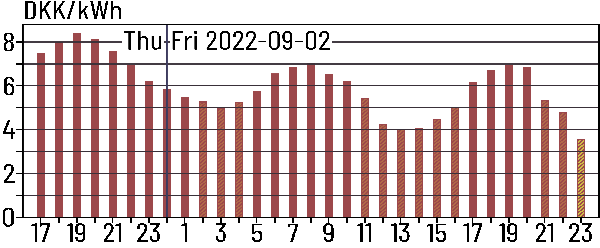

: 

In [8]:
from PIL.Image import Dither
buf = io.BytesIO()

fig.savefig(buf, format="png", dpi=dpi,bbox_inches='tight')
fig.savefig('elpanel_plot.png', format="png", dpi=dpi)
buf.seek(0)
plot_image = Image.open(buf).convert("RGB")
newsize = (hsize, vsize)
im1 = plot_image.resize(newsize, Dither.NONE)
display(im1)
buf.close()

In [48]:
El_data

,Date,Time,Datetime,Price,Hour,Weekday,WeekHour,Tier,Color,RGB
0,2022-09-02,10:00:00,2022-09-02 10:00:00,6.217,10,Fri,Fri10,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
1,2022-09-02,11:00:00,2022-09-02 11:00:00,5.442,11,Fri,Fri11,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
2,2022-09-02,12:00:00,2022-09-02 12:00:00,4.222,12,Fri,Fri12,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
3,2022-09-02,13:00:00,2022-09-02 13:00:00,4.029,13,Fri,Fri13,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
4,2022-09-02,14:00:00,2022-09-02 14:00:00,4.046,14,Fri,Fri14,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
5,2022-09-02,15:00:00,2022-09-02 15:00:00,4.473,15,Fri,Fri15,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
6,2022-09-02,16:00:00,2022-09-02 16:00:00,5.008,16,Fri,Fri16,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
7,2022-09-02,17:00:00,2022-09-02 17:00:00,6.141,17,Fri,Fri17,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
8,2022-09-02,18:00:00,2022-09-02 18:00:00,6.706,18,Fri,Fri18,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
9,2022-09-02,19:00:00,2022-09-02 19:00:00,6.931,19,Fri,Fri19,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."


In [49]:
LowPriceIdx = El_data.Color[El_data.Price < El_data.Price.quantile(.2)]
El_data.Color[El_data.Price < El_data.Price.quantile(.2)] = 'orange'
El_data

/tmp/ipykernel_4653/2517533406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  El_data.Color[El_data.Price < El_data.Price.quantile(.2)] = 'orange'


,Date,Time,Datetime,Price,Hour,Weekday,WeekHour,Tier,Color,RGB
0,2022-09-02,10:00:00,2022-09-02 10:00:00,6.217,10,Fri,Fri10,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
1,2022-09-02,11:00:00,2022-09-02 11:00:00,5.442,11,Fri,Fri11,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
2,2022-09-02,12:00:00,2022-09-02 12:00:00,4.222,12,Fri,Fri12,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
3,2022-09-02,13:00:00,2022-09-02 13:00:00,4.029,13,Fri,Fri13,"(0.611764705882353, 0.2823529411764706, 0.2941...",orange,"(0.611764705882353, 0.2823529411764706, 0.2941..."
4,2022-09-02,14:00:00,2022-09-02 14:00:00,4.046,14,Fri,Fri14,"(0.611764705882353, 0.2823529411764706, 0.2941...",orange,"(0.611764705882353, 0.2823529411764706, 0.2941..."
5,2022-09-02,15:00:00,2022-09-02 15:00:00,4.473,15,Fri,Fri15,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
6,2022-09-02,16:00:00,2022-09-02 16:00:00,5.008,16,Fri,Fri16,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
7,2022-09-02,17:00:00,2022-09-02 17:00:00,6.141,17,Fri,Fri17,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
8,2022-09-02,18:00:00,2022-09-02 18:00:00,6.706,18,Fri,Fri18,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
9,2022-09-02,19:00:00,2022-09-02 19:00:00,6.931,19,Fri,Fri19,"(0.611764705882353, 0.2823529411764706, 0.2941...",red,"(0.611764705882353, 0.2823529411764706, 0.2941..."
